In [ ]:
# ArUco Marker 좌표 추정

import cv2
import numpy as np
import cv2.aruco as aruco
from IPython.display import clear_output
from collections import deque

cap = cv2.VideoCapture('/dev/video2')

aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_4X4_50)
parameters = aruco.DetectorParameters()

data = np.load('/home/choigh/WS/Test_Tools_code/calib_data.npz')
camera_matrix = data['mtx']
dist_coeffs = data['dist']
marker_length = 0.03

recent_values = deque(maxlen=10)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    corners, ids, rejected = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)

    if ids is not None:
        rvecs, tvecs, _ = aruco.estimatePoseSingleMarkers(corners, 0.03, camera_matrix, dist_coeffs)

        for i in range(len(ids)):
            aruco.drawDetectedMarkers(frame, corners, ids)
            cv2.drawFrameAxes(frame, camera_matrix, dist_coeffs, rvecs[i], tvecs[i], 0.03)

            # 거리 정보 출력
            recent_values.append((ids[i][0], tvecs[i][0][0], tvecs[i][0][1], tvecs[i][0][2]))

            clear_output(wait=True)
            for id_, x, y, z in list(recent_values)[-10:]:
                print(f"ID {id_} | X={x:.3f}  Y={y:.3f}  Z={z:.3f}")
            

            # 화면 표시용 텍스트
            cX, cY = int(corners[i][0][0][0]), int(corners[i][0][0][1])
            cv2.putText(frame, f"ID:{ids[i][0]} Z={z:.2f}m", (cX, cY - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    cv2.imshow("Aruco Detection", frame)
    if cv2.waitKey(1) & 0xFF == 27:  # ESC to exit
        break

cap.release()
cv2.destroyAllWindows()


# # 마커 좌표 정확도 확인
# tvec_history = []
# for _ in range(100):
#     if ids is not None:
#         tvec_history.append(tvecs[0][0])  # 첫 번째 마커만 추적

# tvec_history = np.array(tvec_history)
# mean = np.mean(tvec_history, axis=0)
# std = np.std(tvec_history, axis=0)
# print(f"평균 좌표: {mean}")
# print(f"표준편차(오차): {std}")

ID 1 | X=-0.008  Y=0.015  Z=0.156
ID 1 | X=-0.007  Y=0.016  Z=0.155
ID 1 | X=-0.007  Y=0.016  Z=0.155
ID 1 | X=-0.007  Y=0.016  Z=0.156
ID 1 | X=-0.006  Y=0.015  Z=0.155
ID 1 | X=-0.006  Y=0.014  Z=0.155
ID 1 | X=-0.006  Y=0.013  Z=0.155
ID 1 | X=-0.006  Y=0.013  Z=0.154
ID 1 | X=-0.006  Y=0.012  Z=0.154
ID 1 | X=-0.006  Y=0.012  Z=0.154


In [ ]:
# EE position, orientation

import rclpy
from rclpy.node import Node
from sensor_msgs.msg import JointState
from moveit_msgs.srv import GetPositionFK
from moveit_msgs.msg import RobotState
from tf_transformations import euler_from_quaternion

class FKClient(Node):
    def __init__(self):
        super().__init__('fk_client')
        self.fk_client = self.create_client(GetPositionFK, '/compute_fk')
        self.subscription = self.create_subscription(JointState, '/joint_states', self.joint_callback, 10)
        
        # 서비스가 준비될 때까지 대기
        while not self.fk_client.wait_for_service(timeout_sec=1.0):
            self.get_logger().info('Waiting for /compute_fk service...')

    def joint_callback(self, msg):
        # FK 서비스 요청 생성
        request = GetPositionFK.Request()
        request.header.frame_id = 'world'  # 기준 좌표계
        request.fk_link_names = ['end_effector_link']    # FK를 계산할 링크 이름 (EE link 이름 확인 필요!)
        robot_state = RobotState()
        robot_state.joint_state = msg
        request.robot_state = robot_state

        # 비동기 서비스 호출
        future = self.fk_client.call_async(request)
        future.add_done_callback(self.fk_response_callback)

    def fk_response_callback(self, future):
        try:
            response = future.result()
            if len(response.pose_stamped) > 0:
                pose = response.pose_stamped[0].pose

                x, y, z = pose.position.x, pose.position.y, pose.position.z

                qx, qy, qz, qw = pose.orientation.x, pose.orientation.y, pose.orientation.z, pose.orientation.w
                quat = [qx, qy, qz, qw]
                roll, pitch, yaw = euler_from_quaternion(quat)

                print(f"EE position → x: {x:.3f}, y: {y:.3f}, z: {z:.3f}")
                # print(f"EE orientation (quaternion) → x: {qx:.3f}, y: {qy:.3f}, z: {qz:.3f}, w: {qw:.3f}")
                print(f"RPY → roll: {roll:.3f}, pitch: {pitch:.3f}, yaw: {yaw:.3f}")

            else:
                print("No FK result returned.")
        except Exception as e:
            print(f"FK call failed: {e}")

# 실행
rclpy.init()
node = FKClient()
try:
    rclpy.spin(node)
except KeyboardInterrupt:
    print("종료됨")
finally:
    node.destroy_node()
    rclpy.shutdown()

In [ ]:
# Aruco Marker, EE position, Orientation 추출방법

import cv2
import cv2.aruco as aruco
import numpy as np
from collections import deque
import rclpy
from rclpy.node import Node
from sensor_msgs.msg import JointState
from moveit_msgs.srv import GetPositionFK
from moveit_msgs.msg import RobotState
from tf_transformations import euler_from_quaternion
import threading
import os

# ArUco Marker coord
cap = cv2.VideoCapture('/dev/video2')
aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_4X4_50)
parameters = aruco.DetectorParameters()

marker_length = 0.03

# rvecs, tvecs save
rvecs_list, tvecs_list = [], []
ee_pose = []
save_dir = "t_rvec_ee_list"
count = 1
os.makedirs(save_dir, exist_ok=True)
data = np.load('/home/choigh/WS/Test_Tools_code/calib_data.npz')
camera_matrix = data['mtx']
dist_coeffs = data['dist']


# ee pose
class FKClient(Node):
    def __init__(self):
        super().__init__('fk_client')
        self.fk_client = self.create_client(GetPositionFK, '/compute_fk')
        self.subscription = self.create_subscription(JointState, '/joint_states', self.joint_callback, 10)
        
        # 최신 EE Pose 저장 변수
        self.current_position = None
        self.current_orientation = None
        
        # 서비스가 준비될 때까지 대기
        while not self.fk_client.wait_for_service(timeout_sec=1.0):
            self.get_logger().info('Waiting for /compute_fk service...')

    def joint_callback(self, msg):
        # FK 서비스 요청 생성
        request = GetPositionFK.Request()
        request.header.frame_id = 'world'  # 기준 좌표계
        request.fk_link_names = ['end_effector_link']    # FK를 계산할 링크 이름 (EE link 이름 확인 필요!)
        robot_state = RobotState()
        robot_state.joint_state = msg
        request.robot_state = robot_state

        # 비동기 서비스 호출
        future = self.fk_client.call_async(request)
        future.add_done_callback(self.fk_response_callback)

    def fk_response_callback(self, future):
        try:
            response = future.result()
            if len(response.pose_stamped) > 0:
                pose = response.pose_stamped[0].pose

                x, y, z = pose.position.x, pose.position.y, pose.position.z

                qx, qy, qz, qw = pose.orientation.x, pose.orientation.y, pose.orientation.z, pose.orientation.w
                quat = [qx, qy, qz, qw]
                roll, pitch, yaw = euler_from_quaternion(quat)

                # print(f"EE position → x: {x:.3f}, y: {y:.3f}, z: {z:.3f}")
                # print(f"RPY → roll: {roll:.3f}, pitch: {pitch:.3f}, yaw: {yaw:.3f}")
                # 최신 EE Pose 저장 변수
                self.current_position = [x, y, z]
                self.current_orientation = [roll, pitch, yaw]

            else:
                print("No FK result returned.")
        except Exception as e:
            print(f"FK call failed: {e}")

if not rclpy.ok():
    rclpy.init()

fk_node = FKClient()

ros_thread = threading.Thread(target=rclpy.spin, args=(fk_node,), daemon=True)
ros_thread.start()


# ArUco Marker
while True:
    ret, frame = cap.read()
    key = cv2.waitKey(1) & 0xFF
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    corners, ids, rejected = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)

    if ids is not None:
        rvecs, tvecs, _ = aruco.estimatePoseSingleMarkers(corners, 0.03, camera_matrix, dist_coeffs)

        for i in range(len(ids)):
            aruco.drawDetectedMarkers(frame, corners, ids)
            cv2.drawFrameAxes(frame, camera_matrix, dist_coeffs, rvecs[i], tvecs[i], 0.03)

            # 화면 표시용 텍스트
            cX, cY = int(corners[i][0][0][0]), int(corners[i][0][0][1])
            

            cv2.putText(frame, f"ID:{ids[i][0]} Z={tvecs[i][0][2]:.2f}m", (cX, cY - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            
            # 스페이스바 누르면 저장
            if key == 32:  # Spacebar
                tvecs_list.append([count, tvecs[i][0][0], tvecs[i][0][1], tvecs[i][0][2]])
                rvecs_list.append([count, rvecs[i][0][0], rvecs[i][0][1], rvecs[i][0][2]])
                print(f"Num {count} | X={tvecs[i][0][0]:.3f}  Y={tvecs[i][0][1]:.3f}  Z={tvecs[i][0][2]:.3f}")
                
                if fk_node.current_position is not None:
                    x, y, z = fk_node.current_position
                    roll, pitch, yaw = fk_node.current_orientation
                    ee_pose.append([x, y, z, roll, pitch, yaw])
                    print(f"EE position → x: {x:.3f}, y: {y:.3f}, z: {z:.3f}")
                    print(f"RPY → roll: {roll:.3f}, pitch: {pitch:.3f}, yaw: {yaw:.3f}")
                count += 1

    cv2.imshow("Aruco Detection", frame)

    if key == 27:  # ESC to exit
        np.savez(os.path.join(save_dir, "t_rvec_ee_list.npz"),
             tvecs=np.array(tvecs_list),
             rvecs=np.array(rvecs_list),
             ee_pose=np.array(ee_pose))

        print(f"\nSaved {len(tvecs_list)} marker + EE samples to {save_dir}/t_rvec_ee_list.npz")
        break

cap.release()
cv2.destroyAllWindows()

# 🧹 ROS 노드 안전 종료
print("\nShutting down ROS node...")
fk_node.destroy_node()
rclpy.shutdown()

# 스레드도 종료 (데몬이지만 안전하게 join)
if ros_thread.is_alive():
    ros_thread.join(timeout=1.0)

print("✅ Node terminated cleanly.")

In [68]:
# data = np.load('/home/choigh/WS/CR_SF_PJT/src/01_CR_PJT/cr_test/t_rvec_ee_list/t_rvec_ee_list.npz')
data = np.load('/home/choigh/WS/CR_SF_PJT/src/01_CR_PJT/cr_test/t_rvec_ee_list_1/t_rvec_ee_list_1.npz')

# 배열 불러오기
tvecs = data['tvecs']
rvecs = data['rvecs']
ee_pose = data['ee_pose']

In [73]:
eyehand_data = pd.DataFrame({
    'count': tvecs[:, 0].astype(int),
    'id': tvecs[:, 1].astype(int),
    'tvec_x': tvecs[:, 2],
    'tvec_y': tvecs[:, 3],
    'tvec_z': tvecs[:, 4],
    'rvec_x': rvecs[:, 1],
    'rvec_y': rvecs[:, 2],
    'rvec_z': rvecs[:, 3],
    'ee_x': ee_pose[:, 0],
    'ee_y': ee_pose[:, 1],
    'ee_z': ee_pose[:, 2],
    'ee_roll': ee_pose[:, 3],
    'ee_pitch': ee_pose[:, 4],
    'ee_yaw': ee_pose[:, 5],
})
print(eyehand_data.head())

   count  id    tvec_x    tvec_y    tvec_z    rvec_x    rvec_y    rvec_z  \
0      1   1  0.000852  0.005027  0.228345 -3.149769 -0.085434 -0.192434   
1      2   1 -0.046016  0.026928  0.238221 -2.996334 -0.043861 -0.114003   
2      3   1  0.065780  0.034237  0.245507 -3.026554 -0.155978  0.091535   
3      4   1  0.066441  0.035532  0.247032  3.236783  0.136862 -0.218529   
4      5   1  0.052108 -0.023059  0.197971 -2.902631 -0.096150 -0.042051   

       ee_x      ee_y      ee_z       ee_roll  ee_pitch    ee_yaw  
0  0.191069  0.328131  0.054134 -1.421080e-17  0.216913  1.071242  
1  0.208636  0.294592  0.097701  5.972717e-17  0.377980  0.982227  
2  0.155001  0.338421  0.100454  0.000000e+00  0.275294  1.170999  
3  0.154496  0.338673  0.099890  0.000000e+00  0.276829  1.172534  
4  0.157212  0.333611  0.064164  0.000000e+00  0.413373  1.160256  


/tmp/ipykernel_7575/2355709261.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([tx, ty, tz, rx, ry, rz], labels=['tx', 'ty', 'tz','rx', 'ry', 'rz'])


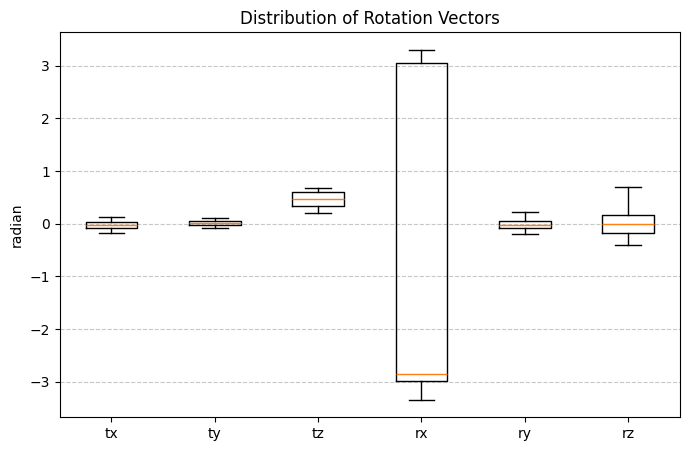

In [79]:
import matplotlib.pyplot as plt
import numpy as np

tx = tvecs[:, 2]
ty = tvecs[:, 3]
tz = tvecs[:, 4]
rx = rvecs[:, 1]
ry = rvecs[:, 2]
rz = rvecs[:, 3]

# boxplot 생성
plt.figure(figsize=(8, 5))
plt.boxplot([tx, ty, tz, rx, ry, rz], labels=['tx', 'ty', 'tz','rx', 'ry', 'rz'])
plt.title('Distribution of Rotation Vectors')
plt.ylabel('radian')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

In [76]:
import cv2
import numpy as np

def normalize_rvec_flips(rvecs):
    """rvec flip(±180deg) 현상 자동 보정"""
    corrected = []
    prev_rvec = None
    for idx, rvec in enumerate(rvecs):
        rvec_vec = np.array(rvec[1:], dtype=float).reshape(3, 1)
        R, _ = cv2.Rodrigues(rvec_vec)

        if prev_rvec is not None:
            prev_R, _ = cv2.Rodrigues(prev_rvec)
            
            if np.trace(prev_R.T @ R) < 3:
                rvec_vec = -rvec_vec  # <-- 여기서 부호 반전해야 함
                R, _ = cv2.Rodrigues(rvec_vec)

        corrected.append([rvec[0], *rvec_vec.flatten()])
        prev_rvec = rvec_vec
    return np.array(corrected)


In [62]:
corrected = normalize_rvec_flips(rvecs)

/tmp/ipykernel_7575/3852053074.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([rx, ry, rz], labels=['rx', 'ry', 'rz'])


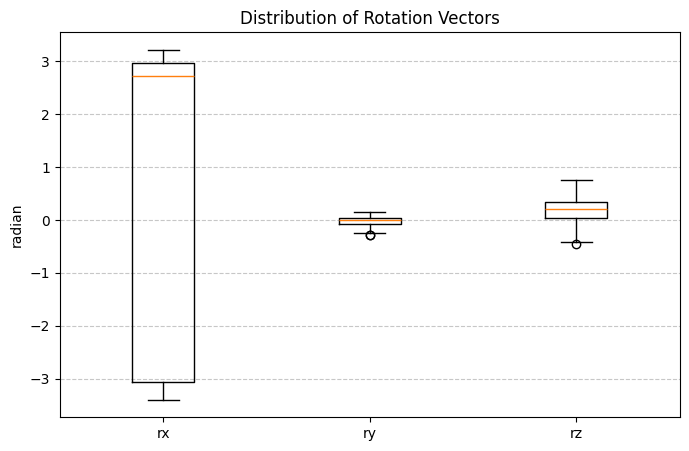

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# corrected가 리스트라면 numpy로 변환
corrected = np.array(corrected)

# 열 분리 (id, rx, ry, rz)
ids = corrected[:, 0]
rx = corrected[:, 1]
ry = corrected[:, 2]
rz = corrected[:, 3]

# boxplot 생성
plt.figure(figsize=(8, 5))
plt.boxplot([rx, ry, rz], labels=['rx', 'ry', 'rz'])
plt.title('Distribution of Rotation Vectors')
plt.ylabel('radian')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# 평균±2π 범위를 벗어난 값 찾기
outliers = np.where(np.abs(rx) > 3.0)[0]
print("Outlier frame IDs:", ids[outliers])
print("Outlier values:", rx[outliers])

Outlier frame IDs: [ 1.  2.  3.  4.  5.  6.  9. 10. 16. 17. 18. 19. 20. 22. 23. 24. 25. 30.]
Outlier values: [-3.16690122 -3.14968002  3.04612191 -3.09860269  3.0210888   3.21424023
  3.08198967  3.11870764 -3.18427501 -3.1616234  -3.04150907 -3.25337468
 -3.07596792 -3.39514171 -3.2151837   3.03800199  3.12417412 -3.06590795]


In [67]:
import os
print(os.getcwd())

/home/choigh/WS/CR_SF_PJT/src/01_CR_PJT/cr_test
